Link collab: https://drive.google.com/file/d/1xhkr0XI25MgbBGsl7jvBdL8bZ55eEySU/view?usp=sharing


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [2]:
###DEBUG###

! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

# decrease height.
from IPython.display import Javascript
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'))

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-y9deu8nq
  Resolved https://github.com/quantiacs/toolbox.git to commit a1e6351446cd936532af185fb519ef92f5b1ac6d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 13.8 MB/s eta 0:00:00
  Created wheel for qnt: filename=qnt-0.0.409-py3-none-any.whl size=115541 sha256=2f04f6130471aef3d9510d06cf62d23d0c9e1d6369ba249c243b1e12b6805a82
  

<IPython.core.display.Javascript object>

In [3]:
import logging
import xarray as xr
import qnt.data as qndata  # functions for loading data
import qnt.backtester as qnbt  # built-in backtester
import qnt.ta as qnta  # technical analysis library
import qnt.stats as qnstats  # statistical functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier  # Replacing linear regression with Random Forest
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error
from qnt.precheck import *  # Precheck library
from sklearn.ensemble import RandomForestClassifier

np.seterr(divide="ignore")

NOTICE: The environment variable API_KEY was not specified. The default value is ''
NOTICE: The environment variable DATA_BASE_URL was not specified. The default value is 'https://data-api.quantiacs.io/'
NOTICE: The environment variable CACHE_RETENTION was not specified. The default value is '7'
NOTICE: The environment variable CACHE_DIR was not specified. The default value is 'data-cache'
Please, specify the API_KEY.
See: https://quantiacs.io/documentation/en/user_guide/local_development.html


SystemExit: 1

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# Lista de activos válidos (ajustada según los datos disponibles)
assets = [
    "NAS:AAPL", "NAS:MSFT", "NAS:GOOGL", "NAS:AMZN", "NAS:META", "NAS:NVDA",
    "NAS:TSLA", "NAS:NFLX", "NAS:ADBE", "NAS:PYPL", "NAS:INTC", "NAS:CSCO",
    "NAS:PEP", "NAS:COST", "NAS:AVGO", "NAS:TXN", "NAS:QCOM", "NAS:AMAT",
    "NAS:INTU", "NAS:AMD"
]

# Cargar datos con validaciones
stock_data = qndata.stocks.load_ndx_data(tail=365 * 10, assets=assets)

# Validar que los datos no estén vacíos
if stock_data.sel(field="close").size == 0:
    raise ValueError("No hay datos disponibles para los activos seleccionados.")

NameError: name 'qndata' is not defined

In [ ]:
# Reemplazo de qnta.bollinger_bands con función personalizada
def bollinger_bands(close_prices, period=20):
    rolling_mean = close_prices.rolling(time=period).mean()
    rolling_std = close_prices.rolling(time=period).std()
    boll_upper = rolling_mean + (rolling_std * 2)
    boll_lower = rolling_mean - (rolling_std * 2)
    return boll_upper, rolling_mean, boll_lower

def get_features(data):
    """Genera características para el modelo."""
    close_price = data.sel(field="close")
    boll_upper, boll_middle, boll_lower = bollinger_bands(close_price, period=20)
    macd, macd_signal, _ = qnta.macd(close_price)
    rsi = qnta.rsi(close_price)
    avg_volume = qnta.sma(data.sel(field="volume"), 20)

    result = xr.concat([
        boll_upper, boll_middle, boll_lower, macd_signal, rsi, avg_volume
    ], pd.Index([
        "boll_upper", "boll_middle", "boll_lower", "macd_signal", "rsi", "avg_volume"
    ], name="field"))

    return result.transpose("time", "field", "asset")

In [ ]:
# Función para definir clases objetivo
def get_target_classes(data):
    price_current = data.sel(field="close")
    price_future = qnta.shift(price_current, -1)
    return xr.where(price_future > price_current, 1, 0)

In [ ]:
# Generar características y clases objetivo
my_features = get_features(stock_data)
my_targetclass = get_target_classes(stock_data)

In [ ]:
# Modelo de Machine Learning
def get_model():
    return RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Entrenamiento por activo
asset_name_all = stock_data.coords["asset"].values
models = {}

for asset_name in asset_name_all:
    # Seleccionar las características y las etiquetas objetivo
    target_cur = my_targetclass.sel(asset=asset_name).dropna("time", how="any")
    features_cur = my_features.sel(asset=asset_name).dropna("time", how="any")

    # Alinear las características y las etiquetas objetivo en el tiempo
    features_cur, target_cur = xr.align(features_cur, target_cur, join="inner")

    # Verificar que haya suficientes datos para el entrenamiento
    if len(features_cur.time) < 10:
        print(f"Datos insuficientes para el activo: {asset_name}")
        continue

    # Crear y entrenar el modelo
    model = get_model()
    try:
        model.fit(features_cur.values, target_cur.values)
        models[asset_name] = model
    except ValueError as e:
        print(f"Error al entrenar el modelo para el activo {asset_name}: {e}")


In [ ]:
# Generar predicciones y pesos
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        # Corregir el uso de dropna con argumentos nombrados
        features_cur = my_features.sel(asset=asset_name).dropna(dim="time", how="any")

        if len(features_cur.time) < 1:
            continue

        predictions = models[asset_name].predict(features_cur.values)
        weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = predictions

In [ ]:
# Calcular el Sharpe Ratio
def get_sharpe(stock_data, weights):
    rr = qnstats.calc_relative_return(stock_data, weights)
    return qnstats.calc_sharpe_ratio_annualized(rr).values[-1]

sharpe = get_sharpe(stock_data, weights)
print("Sharpe Ratio:", sharpe)

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-10,8.452181e+07,-0.001498,0.193355,-0.007192,-0.25681,27.197520,5.258780,1.0,20.0,1.134989,1.583475
2025-01-13,8.491369e+07,0.004637,0.193319,-0.002589,-0.25681,27.194044,5.257113,1.0,20.0,1.135331,1.583155
2025-01-14,8.629121e+07,0.016223,0.193300,0.000000,-0.25681,27.225268,5.262654,1.0,20.0,1.135244,1.582975
2025-01-15,8.816863e+07,0.021757,0.193315,0.000000,-0.25681,27.269477,5.271612,1.0,20.0,1.135323,1.582945
2025-01-16,8.878694e+07,0.007013,0.193277,0.000000,-0.25681,27.273933,5.271425,0.0,20.0,1.135536,1.582912


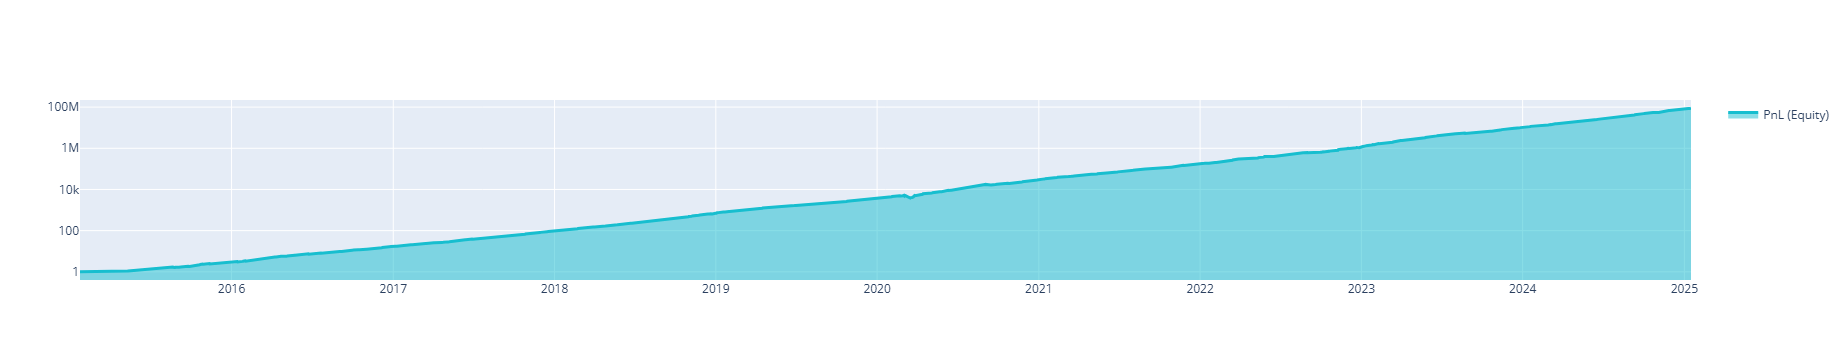

time,2025-01-16
field,
sharpe_ratio,27.273933



Ok. This strategy does not correlate with other strategies.


In [ ]:
import qnt.graph as qngraph

# Filtrar activos líquidos
stock_data = stock_data.where(stock_data.sel(field="is_liquid") > 0).dropna("asset", how="all")

# Calcular estadísticas
statistics = qnstats.calc_stat(stock_data, weights)

# Mostrar estadísticas
display(statistics.to_pandas().tail())

# Graficar rendimiento
performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

# Mostrar Sharpe Ratio
display(statistics[-1:].sel(field=["sharpe_ratio"]).transpose().to_pandas())

# Verificar correlaciones
qnstats.print_correlation(weights, stock_data)

In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Entrena un modelo basado en los datos."""
    asset_names = data.coords["asset"].values
    features = get_features(data)
    targets = get_target_classes(data)
    models = {}

    for asset in asset_names:
        target = targets.sel(asset=asset).dropna("time", how="any")
        feature = features.sel(asset=asset).dropna("time", how="any")

        if len(target.time) < 10:
            print(f"Not enough data to train for asset: {asset}")
            continue

        target, feature = xr.align(target, feature, join="inner")
        model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

        try:
            model.fit(feature.values, target.values)
            models[asset] = model
            print(f"Model trained for asset: {asset}")
        except Exception as e:
            print(f"Failed to train model for {asset}: {str(e)}")

    return models

In [ ]:
def predict_weights(data, models):
    features = get_features(data)
    weights = xr.zeros_like(data['close'])
    for asset_name, model in models.items():
        # Predict weights for each asset using features
        # Adjust the following line according to how features and models are structured
        weights.loc[dict(asset=asset_name)] = model.predict(features.loc[dict(asset=asset_name)])
    return weights

In [ ]:
weights = qnbt.backtest_ml(
    train=train_model,
    predict=predict_weights,
    train_period=2 * 365,  # Período de entrenamiento (en días calendario)
    retrain_interval=10 * 365,  # Intervalo para reentrenar el modelo (en días calendario)
    retrain_interval_after_submit=1,  # Reentrenar después de enviar (1 día)
    predict_each_day=False,  # No predecir cada día durante el backtesting
    competition_type="stocks_nasdaq100",  # Tipo de competencia
    lookback_period=365,  # Período de retroceso para generar la predicción
    start_date="2005-01-01",  # Fecha de inicio del backtesting
    analyze=True,  # Analizar los resultados
    build_plots=True  # Construir gráficos
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s
Model trained for asset: NAS:AAL
Model trained for asset: NAS:AAPL
Model trained for asset: NAS:ABNB
Model trained for asset: NAS:ADBE
Failed to train model for NAS:ADCT: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by RandomForestClassifier.
Model trained for asset: NAS:ADI
Model trained for asset: NAS:ADP
Model trained for asset: NAS:ADSK
Model trained for asset: NAS:AEP
Model trained for asset: NAS:AKAM
Model trained for asset: NAS:ALGN
Model trained for asset: NAS:ALTR
Failed to train model for NAS:ALTR~1: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by RandomForestClassifier.
Failed to train model for NAS:ALXN: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by RandomForestClassifier.
Model trained for asset: NAS:AMAT
Failed to train model for NAS:AMCC: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required

AttributeError: 'dict' object has no attribute 'sel'

The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!